# Using Reuters Headlines to Predict the S&P 500

### Project Goal:

*News sources like Reuters has an extensive history of providing relevant updates to investors. By scraping data from Reuters and using the headlines of the day, is it possible to use a sentiment analysis library to determine the most important words that determine whether or not the S&P 500 will close higher than it did the previous day?*

### Results:
> *Both the Random Forest Classifier and Linear SVM do better than average at predicting whether or not the S&P 500 will close higher than the previous day*.

> **Highest Accuracy Score**: 68% (Random Forest)  
**Highest Auc Score**: 75% (Random Forest)  
**Best True Positive Rate**: 78% (Linear SVM)  
**Best True Negative Rate**: 67% (Random Forest)

### Methodology:
 
>1. Scraped data of Reuters news headlines is passed into Sklearn's TfidfVectorizer.  
2. Stock data from S&P 500 is from Python's yfinance library. The labels are determined by the 'Close' price of each day. The label is 1 if the 'Close' price was higher than the previous day, and 0 otherwise.
3. The data of scores from TfidfVectorizer and labels from the S&P 500 are passed into various machine learning models.
4. The models are verified using Confusion Matrices, Precision-Recall Curves, and ROC-AUC Curves.

In [1]:
#Importing Libraries

import pandas as pd
import numpy as np
import yfinance as yf
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import re

# Sklearn Libraries
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer


# Accuracy Score Libraries
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, cross_val_score

# Machine Learning Models
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC


warnings.filterwarnings('ignore')
sns.set_style('darkgrid')

# Reading / Cleaning Data

In [2]:
df = pd.read_csv('reuters_headlines.csv')
df = df[['Headlines', 'Time']]
df.columns = ['headlines', 'date']
df.head()

,headlines,date
0,TikTok considers London and other locations fo...,Jul 18 2020
1,Disney cuts ad spending on Facebook amid growi...,Jul 18 2020
2,Trail of missing Wirecard executive leads to B...,Jul 18 2020
3,Twitter says attackers downloaded data from up...,Jul 18 2020
4,U.S. Republicans seek liability protections as...,Jul 17 2020


> *Currently, each record is a headline and description. We need to transform the dataframe so that each row is a day containing a list of headlines.*

In [3]:
df = df.groupby('date').headlines.apply(list).reset_index()

> *Example of the headlines:*

In [4]:
print('Date: {}'.format(df['date'][0]))
print('Headlines: {}'.format(df['headlines'][0]))

Date: Apr 01 2018
Headlines: ['As corporate-government tax pacts falter, Coca-Cola challenges huge U.S. bill', 'Trump attacks Amazon, again, over U.S. postal rates', 'Volkswagen shareholder against reelection of Wolfgang Porsche to board: report', "Fox's Ingraham taking vacation as advertisers flee amid controversy"]


> *Let's also convert the 'date' column to datetime, and set it as the index.*

In [5]:
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')
df = df.sort_index()

> *Finding the range of dates:*

In [6]:
print('First Date: {}'.format(df.head(1).index[0]))
print('First Date: {}'.format(df.tail(1).index[0]))

First Date: 2018-03-20 00:00:00
First Date: 2020-07-18 00:00:00


> *Since the data come from Reuters Finance, each headline will contain news about the general happenings in the business world. However, before it can be passed into a machine learning model, it needs to be sanitized. The steps to do this goes as follows:*
> 1. *Split the list of strings by space*  
> 2. *Use Regex to replace any occurence of a non-alphanumeric character with an empty space* 
> 3. *Convert each word to lowercase*

In [7]:
def sanitize(lst):
    temp = ""
    for k in lst:
        split = k.split(' ')
        for word in split:
            word = re.sub(r'[^a-zA-Z]', ' ', word)
            word = word.lower()
            temp += word + " "
    return temp

In [8]:
df['headlines'] = df['headlines'].apply(lambda x : sanitize(x))

> *Example of the sanitized headline:*

In [9]:
print('Date: {}'.format(df.index[0]))
print('Headlines: {}'.format(df['headlines'][0]))

Date: 2018-03-20 00:00:00
Headlines: asian business sentiment edges up to hit seven year high  thomson reuters insead new zealand court rejects megaupload founder s call for obama appearance former pboc governor  china will continue to adopt proactive fiscal  neutral monetary policies blackstone co founder peter peterson dies  aged    expedia s orbitz says         payment cards hit in breach weinstein co says its bankruptcy filing won t protect ex chairman japan gets its way at g   on warning against recent market rout social media stocks tumble as wall street fears regulation nordstorm ends talks with founding family on take private offer salesforce to buy mulesoft for      billion g   talks on trade  constructive   no concern of trade war  argentina treasury s mnuchin says u s  tariffs  not about protectionism  france s le maire blames  unfair trade  for global commerce woes mnuchin says u s  won t start a trade war  brazil s meirelles spotify ceo eligible to sell up to    billion st

# Getting S&P 500 Historical Data

> *The S&P 500 is a stock index that provides an idea of how the general economy is doing. Since the Reuters headlines may contain information about any company, a better idea is to use the headlines to try and determine how the general economy is doing. To get S&P historical data, we will use the Python yfinance library.* 

In [10]:
snp = yf.Ticker('^GSPC')
snp = snp.history(start='2018-03-20', end='2020-07-18').reset_index()
snp.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2018-03-20,2715.050049,2724.219971,2710.050049,2716.939941,3261030000,0,0
1,2018-03-21,2714.989990,2739.139893,2709.790039,2711.929932,3415510000,0,0
2,2018-03-22,2691.360107,2695.679932,2641.590088,2643.689941,3739800000,0,0
3,2018-03-23,2646.709961,2657.669922,2585.889893,2588.260010,3815080000,0,0
4,2018-03-26,2619.350098,2661.360107,2601.810059,2658.550049,3511100000,0,0


> *Now we will need to get the labels for our machine learning model. The labels will be determined by the 'Close' price: 1 if the S&P 500 closed higher than the previous day, and 0 otherwise.*

In [11]:
def get_labels(data):
    idx = 1
    for i, row in data.iterrows():
        if (idx >= len(data)):
            break
        
        if data.iloc[idx, 3] > data.iloc[i, 3]:
            data.at[idx, 'label'] = 1
        else:
            data.at[idx, 'label'] = 0
        idx = idx + 1

get_labels(snp)
snp = snp.set_index('Date')
snp = snp.sort_index()
snp.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,label
Date,,,,,,,,
2018-03-20,2715.050049,2724.219971,2710.050049,2716.939941,3261030000,0,0,NaN
2018-03-21,2714.989990,2739.139893,2709.790039,2711.929932,3415510000,0,0,0.0
2018-03-22,2691.360107,2695.679932,2641.590088,2643.689941,3739800000,0,0,0.0
2018-03-23,2646.709961,2657.669922,2585.889893,2588.260010,3815080000,0,0,0.0
2018-03-26,2619.350098,2661.360107,2601.810059,2658.550049,3511100000,0,0,1.0


> *The first date contains a null value because there is nothing to compare it to. To fix this, I looked for the opening price on 03/19/2018, which was 2710. The label for the first row will be replaced with a 1.*

In [12]:
snp = snp.fillna(1)

# Merging Reuters Headlines and Labeled S&P Data

> *The data will be merged, resulting in a dataframe with a date, string of headlines, and a label*

In [13]:
snp_label = snp[['label']]
df = df.merge(snp_label, how='inner', left_index=True, right_index=True)
df.head()

,headlines,label
2018-03-20,asian business sentiment edges up to hit seven...,1.0
2018-03-21,arizona police release video of fatal collisio...,0.0
2018-03-22,japan s aso says closely watching u s tariff ...,0.0
2018-03-23,globalists buck u s index fund trend japan ma...,0.0
2018-03-26,hyundai s union says revised trade deal with u...,1.0


# Splitting Data to Test and Train

In [14]:
X = df['headlines']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .33, random_state=True)

In [15]:
df.sort_index().tail()

,headlines,label
2020-07-13,first companies obtain regulatory approval for...,1.0
2020-07-14,internal u s small business watchdog launches...,0.0
2020-07-15,china s economy will continue recovery in seco...,1.0
2020-07-16,united airlines pilots union reach creative d...,0.0
2020-07-17,u s republicans seek liability protections as...,1.0


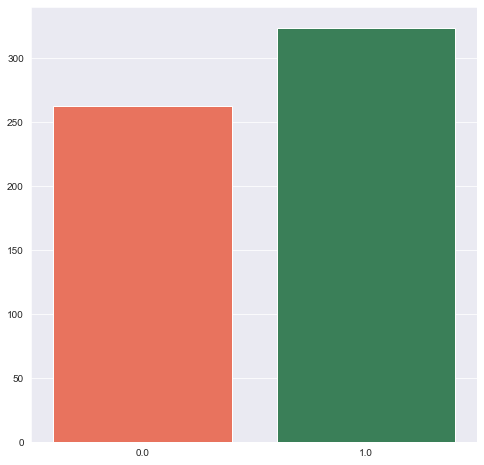

In [19]:
fig = plt.figure(figsize = (8,8))
sns.barplot(x = df.label.value_counts().index, y = df.label.value_counts().values, palette = ['tomato', 'seagreen'])

# Setting Up TfidfVectorizer

*Using Sklearn's [TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html), which converts a collection of raw documents (strings in this case) to a matrix of TF-IDF features.*     

*A TF-IDF feature is a statistical measure that evaluates how relavant a word is to a document. The library will find how many times a word appears in a document, and multiplies it by the inverse frequency of the words across the document.*  

*Esentially, the goal is to use TfidfVectorizer to find common words that appear when the market closes higher than the previous day, and use a machine learning model to determine which words are most relevant*  

> *The first step is to get each headline into one list to pass into the vectorizer:*

In [553]:
def get_all_headlines(data):
    headlines = []
    for i in data.headlines:
        headlines.append(i)
    return headlines

In [554]:
#Getting all headlines for the train and test splits
train_hl = get_all_headlines(X_train.to_frame())
test_hl = get_all_headlines(X_test.to_frame())

> *The second step is to pass the headlines into TfidfVectorizer.*  

>*We specify ngram_range to be (2,2), which means instead of finding the most relevant words, it will find the most relevant groups of 2 words. This will help with finding relavant keywords and will limit overfitting.*  


>*Also, the keyword 'english' is passed into stop_words, which means it will ignore common English words like "is, the, as", etc.*

In [555]:
vect = TfidfVectorizer(ngram_range = (2,2), stop_words = 'english')
vect.build_analyzer()
vect.build_preprocessor()


train_vect = vect.fit_transform(train_hl)
test_vect = vect.transform(test_hl)

# Machine Learning Models

In [720]:
# Defining a confusion matrix plot for easy plotting

def conf_mat(y_true, y_pred):
    plt.figure(figsize = (8,6))
    labels = {"Down" : 0,
             "Up" : 1}
    
    
    mat = confusion_matrix(y_true, y_pred)
    plot = sns.heatmap(mat, annot=True, fmt = "d", linewidths = 1, cmap = "Blues", xticklabels = labels.keys(), yticklabels = labels.keys())
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig('confmatlsvm.png')
    return plot

##  RandomForestClassifier

In [557]:
rf = RandomForestClassifier(n_estimators = 300, criterion = 'gini', class_weight='balanced')
rf.fit(train_vect, y_train)
rf_pred = rf.predict(test_vect)

RandomForestClassifier(class_weight='balanced', n_estimators=300)

##### Confusion Matrix

> *The confusion matrix shows that the model was 71% accurate at predicting 'Down' when the true label was down, and 66% accurate when predicting 'Up' when the true label was up.*

<AxesSubplot:xlabel='Predicted Label', ylabel='True Label'>

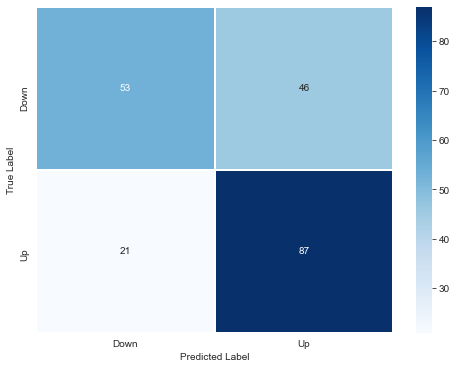

In [717]:
conf_mat(y_test, rf_pred)

##### Precision-Recall Curve

> *The Precision-Recall Curve shows us that the precision is quite high, but the recall drops off as the precision gets lower. This means the model is very good at determining labels, but as more data is fed in, the accuracy drops off.*

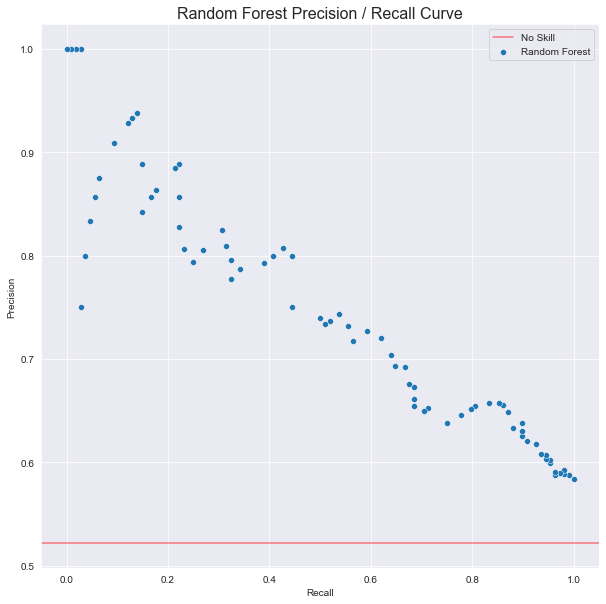

In [728]:
rf_probs = rf.predict_proba(test_vect)[:,1]

prec, recall, _ = precision_recall_curve(y_test, rf_probs)
random = len(y_test[y_test == 1]) / len(y_test)

fig = plt.figure(figsize = (10,10))
sns.scatterplot(recall, prec, label = 'Random Forest')
plt.axhline(random, label = 'No Skill', color = 'red', alpha = .5)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Random Forest Precision / Recall Curve', fontsize = 16)
plt.legend()

plt.savefig('prcurve_rf.png')
plt.show()

##### Roc-Auc Curve

> *The Roc-Auc Curve shows us that the Random Forest model is better than average, which is represented by the red line. Looking at the 40% FPR (gray line), the model gets around 70% of the labels correctly. There is a tradeoff here, but it is better than random guessing.*

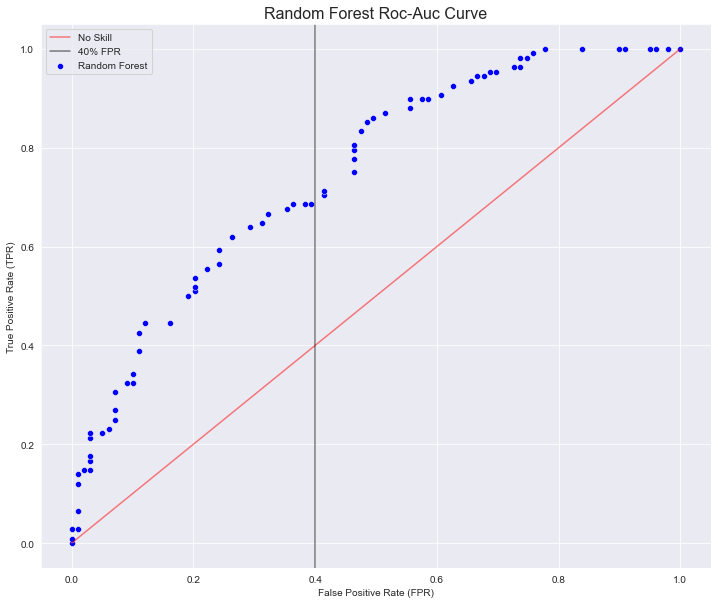

In [729]:
zero_probs = np.zeros(len(y_test))
zero_auc = roc_auc_score(y_test, zero_probs)
real_auc = roc_auc_score(y_test, rf_probs)

zero_fpr, zero_tpr, _ = roc_curve(y_test, zero_probs)
real_fpr, real_tpr, _ = roc_curve(y_test, rf_probs)

fig = plt.figure(figsize = (12,10))
sns.scatterplot(real_fpr, real_tpr, label = 'Random Forest', color = 'blue')
sns.lineplot(zero_fpr, zero_tpr, label = 'No Skill', color = 'red', alpha = .5)
plt.axvline(.4, alpha = .5, color = 'black', label = '40% FPR')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Random Forest Roc-Auc Curve', fontsize = 16)

plt.savefig('rfrocauc.png')
plt.legend()
plt.show()

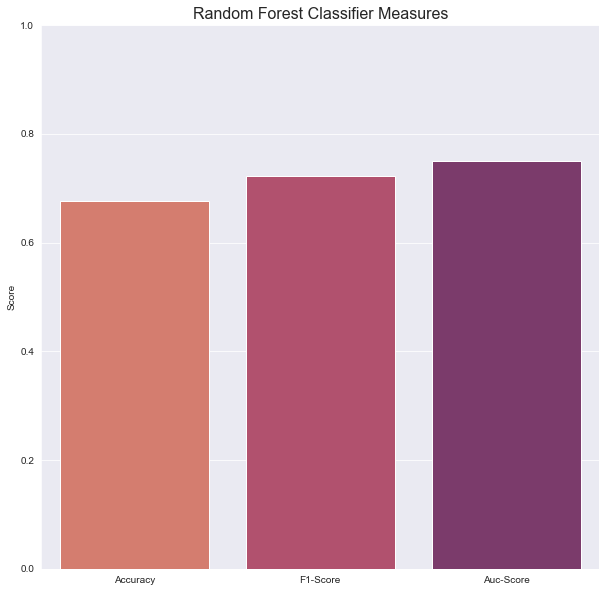

In [730]:
scores = pd.DataFrame({'Accuracy' : [accuracy_score(y_test, rf_pred)], 
                      'F1-Score' : [f1],
                      'Auc-Score' : [real_auc]})
score_lst = [accuracy_score(y_test, rf_pred), f1, real_auc]
index = ['Accuracy', 'F1-Score', 'Auc-Score']

rf_scores = pd.DataFrame(list(zip(index, score_lst)), columns = ['Measure', 'Score'])

fig = plt.figure(figsize = (10,10))
sns.barplot(x = 'Measure', y = 'Score', data = rf_scores, palette = 'flare')

plt.title('Random Forest Classifier Measures', fontsize = 16)
plt.xlabel('')
plt.ylim(0,1)
plt.savefig('rfmeasures.png')
plt.show()

In [671]:
print('Accuracy Score: {}'.format(rf_scores.iloc[0, 1]))
print('F1-Score Score: {}'.format(rf_scores.iloc[1, 1]))
print('AUC-Score Score: {}'.format(rf_scores.iloc[2, 1]))  

Accuracy Score: 0.6763285024154589
F1-Score Score: 0.7219917012448134
AUC-Score Score: 0.749485596707819


# XGBoost

In [565]:
xg = XGBClassifier(n_estimators=300)
xg.fit(train_vect, y_train)
xg_pred = xg.predict(test_vect)

[14:07:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


##### Confusion Matrix

> *Compared to Random Forest, XGBoost does slightly worse. It does well at predicting the true Up labels (70%), but seems to get confused when classifying Down labels (59%).*

<AxesSubplot:xlabel='Predicted Label', ylabel='True Label'>

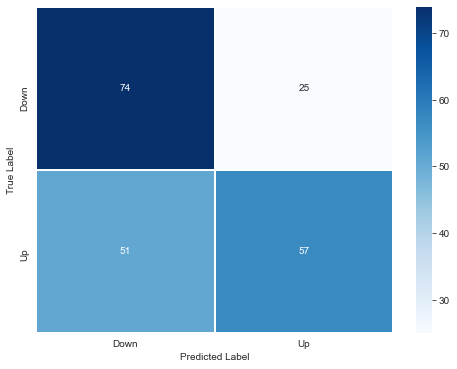

In [719]:
conf_mat(y_test, xg_pred)

##### Precision-Recall Curve

> *The Precision-Recall Curve for XGBoost shows that the model is not very good. Compared to Random Forest's PR-Curve, this one dips as recall hits .15*

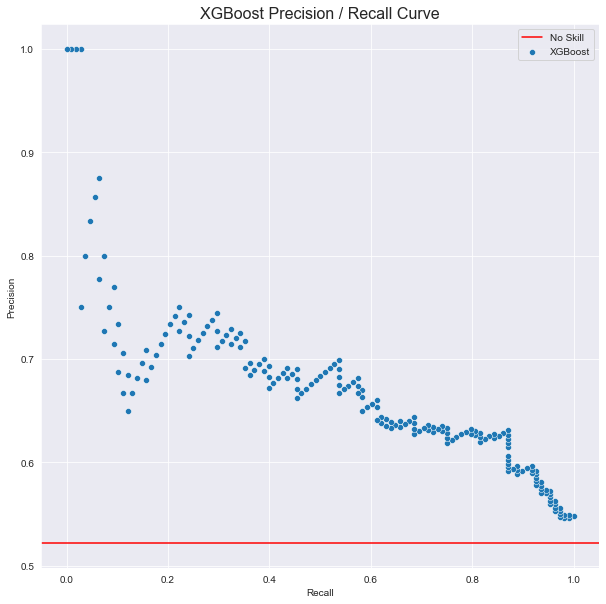

In [732]:
xg_probs = xg.predict_proba(test_vect)[:,1]
prec, recall, _ = precision_recall_curve(y_test, xg_probs)

random = len(y_test[y_test == 1]) / len(y_test)
fig = plt.figure(figsize = (10,10))
sns.scatterplot(recall, prec, label = 'XGBoost')

plt.axhline(random, label = 'No Skill', color = 'red')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('XGBoost Precision / Recall Curve', fontsize = 16)
plt.legend()
plt.savefig('xgpr.png')
plt.show()

##### Roc-Auc Curve

> *Compared to Random Forest, XGBoost shows a 60% TPR when there is a 40% FPR. This tradeoff shows it is better than average, but when taking the PR-Curve into account, this model probably should not be trusted*

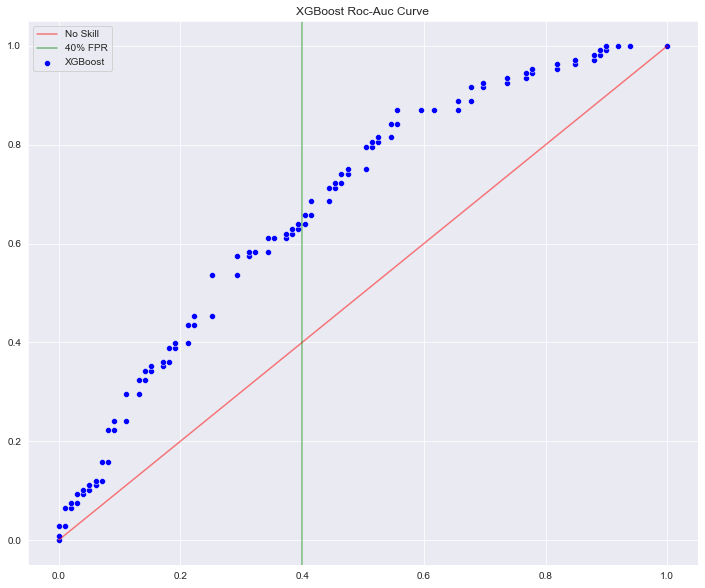

In [733]:
zero_probs = np.zeros(len(y_test))
zero_auc = roc_auc_score(y_test, zero_probs)
real_auc = roc_auc_score(y_test, xg_probs)

zero_fpr, zero_tpr, _ = roc_curve(y_test, zero_probs)
real_fpr, real_tpr, _ = roc_curve(y_test, xg_probs)

fig = plt.figure(figsize = (12,10))
sns.scatterplot(real_fpr, real_tpr, label = 'XGBoost', color = 'blue')
sns.lineplot(zero_fpr, zero_tpr, label = 'No Skill', color = 'red', alpha = .5)
plt.axvline(.4, alpha = .5, color = 'green', label = '40% FPR')
plt.xlabel('')
plt.title('XGBoost Roc-Auc Curve')
plt.legend()
plt.savefig('xgra.png')
plt.show()

##### Accuracy Scores

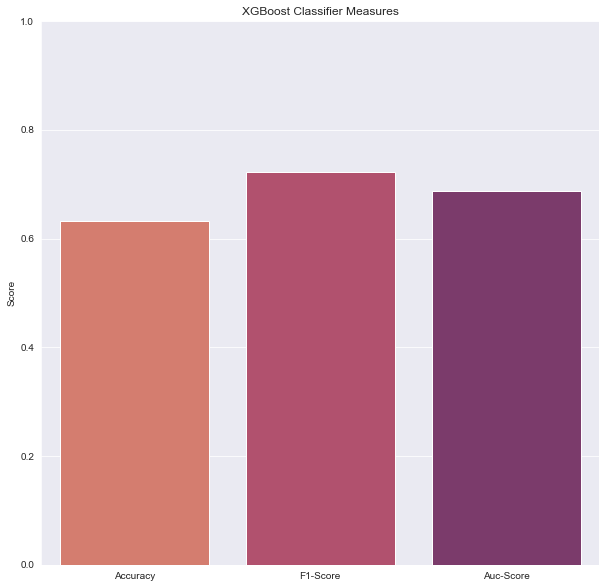

In [734]:
score_lst = [accuracy_score(y_test, xg_pred), f1, real_auc]
index = ['Accuracy', 'F1-Score', 'Auc-Score']

xg_scores = pd.DataFrame(list(zip(index, score_lst)), columns = ['Measure', 'Score'])

fig = plt.figure(figsize = (10,10))
sns.barplot(x = 'Measure', y = 'Score', data = xg_scores, palette = 'flare')

plt.title('XGBoost Classifier Measures')
plt.xlabel('')
plt.ylim(0,1)
plt.savefig('xgclass.png')
plt.show()

In [670]:
print('Accuracy Score: {}'.format(xg_scores.iloc[0, 1]))
print('F1-Score Score: {}'.format(xg_scores.iloc[1, 1]))
print('AUC-Score Score: {}'.format(xg_scores.iloc[2, 1]))  

Accuracy Score: 0.6328502415458938
F1-Score Score: 0.7219917012448134
AUC-Score Score: 0.6878974934530491


# Linear Support Vector Machine

In [722]:
svc = SVC(probability=True, kernel='linear', class_weight = 'balanced')
svc.fit(train_vect, y_train)
svc_pred = svc.predict(test_vect)

##### Confusion Matrix

> *The confusion matrix for LSVM shows that the model does a good job at determining true Down labels (78%) and does better than average for Up labels (64%).*

<AxesSubplot:xlabel='Predicted Label', ylabel='True Label'>

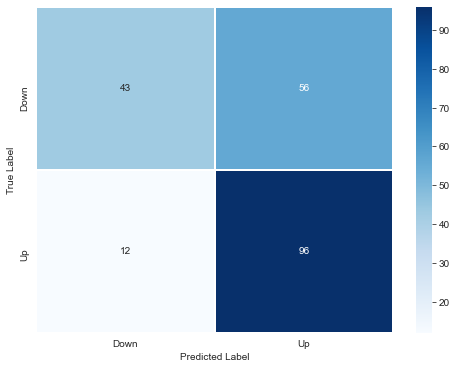

In [723]:
conf_mat(y_test, svc_pred)

##### Precision-Recall Curve

> *The Precision-Recall Curve shows us that the model is better than average. At 40% recall, the model has a precision of around 80%.*

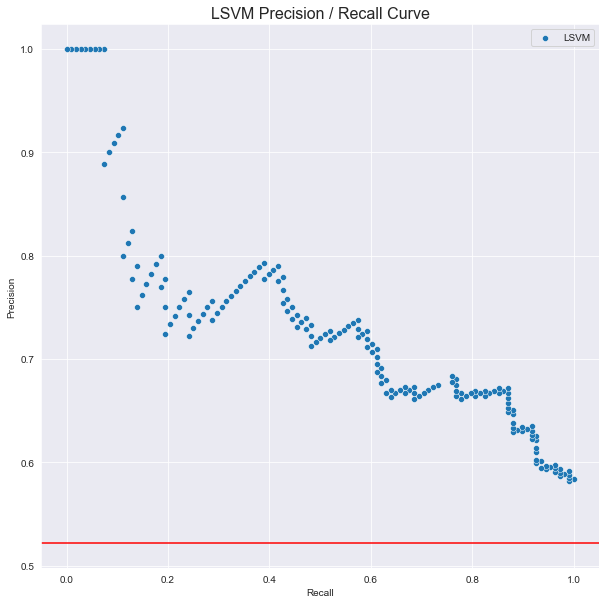

In [735]:
svc_probs = svc.predict_proba(test_vect)[:,1]

prec, recall, _ = precision_recall_curve(y_test, svc_probs)
random = len(y_test[y_test == 1]) / len(y_test)

fig = plt.figure(figsize = (10,10))
sns.scatterplot(recall, prec, label = 'LSVM')


plt.axhline(random, label = 'No Skill', color = 'red')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('LSVM Precision / Recall Curve', fontsize = 16)
plt.legend
plt.savefig('lvsmprc.png')
plt.show()

##### Roc-Auc Curve

> *The Roc-Auc Curve shows us that the model is good. At a 40% FPR, the model gets an 80% TPR. The tradeoff is significant enough to show that the model does much better than average at predictions.*

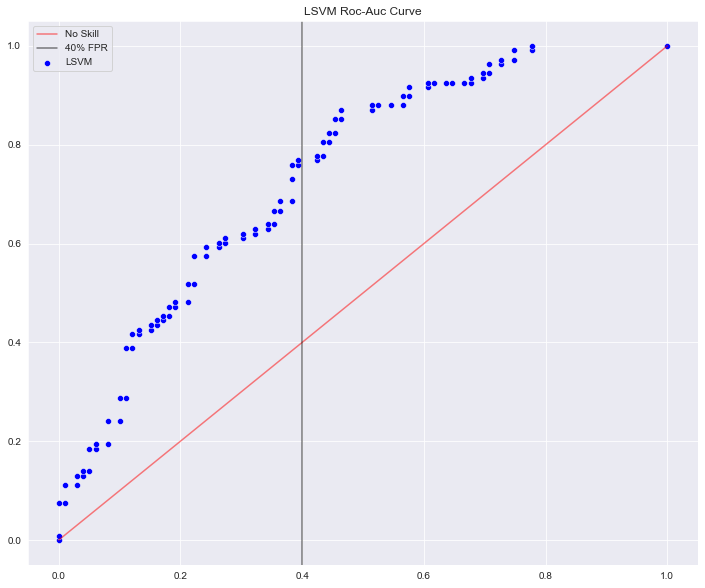

In [737]:
zero_probs = np.zeros(len(y_test))

zero_fpr, zero_tpr, _ = roc_curve(y_test, zero_probs)
real_fpr, real_tpr, _ = roc_curve(y_test, svc_probs)

fig = plt.figure(figsize = (12,10))
sns.scatterplot(real_fpr, real_tpr, label = 'LSVM', color = 'blue')
sns.lineplot(zero_fpr, zero_tpr, label = 'No Skill', color = 'red', alpha = .5)
plt.axvline(.4, alpha = .5, color = 'black', label = '40% FPR')
plt.xlabel('')
plt.title('LSVM Roc-Auc Curve')
plt.savefig('lsvmra.png')
plt.legend()
plt.show()

##### Accuracy Scores

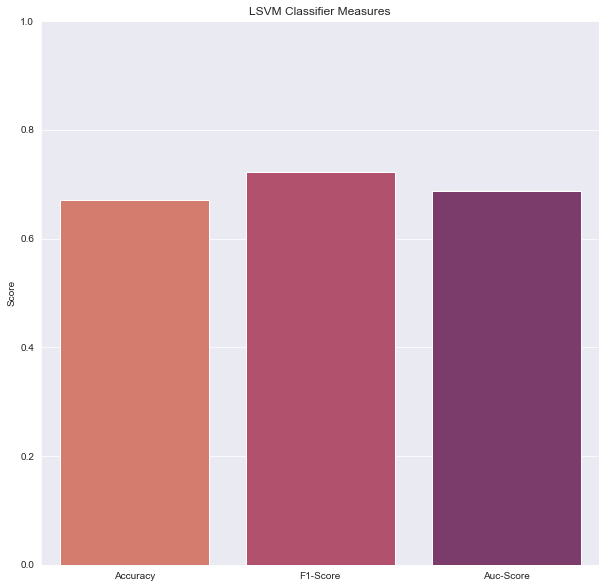

In [738]:
svc_pred = accuracy_score(y_test, svc_pred)
score_lst = [svc_pred, f1, real_auc]
index = ['Accuracy', 'F1-Score', 'Auc-Score']

svc_scores = pd.DataFrame(list(zip(index, score_lst)), columns = ['Measure', 'Score'])

fig = plt.figure(figsize = (10,10))
sns.barplot(x = 'Measure', y = 'Score', data = svc_scores, palette = 'flare')

plt.title('LSVM Classifier Measures')
plt.xlabel('')
plt.ylim(0,1)
plt.savefig('lsvmmeasures.png')
plt.show()

In [669]:
print('Accuracy Score: {}'.format(svc_scores.iloc[0, 1]))
print('F1-Score Score: {}'.format(svc_scores.iloc[1, 1]))
print('AUC-Score Score: {}'.format(svc_scores.iloc[2, 1]))  

Accuracy Score: 0.6714975845410628
F1-Score Score: 0.7219917012448134
AUC-Score Score: 0.6878974934530491


# Summary

*For our sample size, there is definitely value by scraping news headlines. Both the Random Forest and LSVM models have a significant capability to predict whether the S&P 500 will close higher than the previous day. The XGBoost model also does better than average, but with a weak Precision-Recall Curve, it is not on the same level as Random Forest or LSVM. The next steps would be to get more data of headlines from different news sources, try different stock indexes, and try to predict the exact price of the stock based on the times of articles.*